In [32]:
# pip install tensorflow

In [33]:
# !pip install keras_preprocessing

In [34]:
# !pip install tensorflow==2.17.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import  MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [36]:
#!helper_functions
from helper_functions import walk_through_dir # plot_loss_curves, unzip_data, compare_historys, pred_and_plot, create_tensorboard_callback

In [37]:
dataset = "C:/Users/admin/DAP/RealWaste"
walk_through_dir(dataset)

There are 9 directories and 0 images in 'C:/Users/admin/DAP/RealWaste'.
There are 0 directories and 461 images in 'C:/Users/admin/DAP/RealWaste\Cardboard'.
There are 0 directories and 411 images in 'C:/Users/admin/DAP/RealWaste\Food Organics'.
There are 0 directories and 420 images in 'C:/Users/admin/DAP/RealWaste\Glass'.
There are 0 directories and 790 images in 'C:/Users/admin/DAP/RealWaste\Metal'.
There are 0 directories and 495 images in 'C:/Users/admin/DAP/RealWaste\Miscellaneous Trash'.
There are 0 directories and 500 images in 'C:/Users/admin/DAP/RealWaste\Paper'.
There are 0 directories and 921 images in 'C:/Users/admin/DAP/RealWaste\Plastic'.
There are 0 directories and 318 images in 'C:/Users/admin/DAP/RealWaste\Textile Trash'.
There are 0 directories and 436 images in 'C:/Users/admin/DAP/RealWaste\Vegetation'.


In [38]:
image_dir = Path(dataset)

# Lấy đường dẫn tệp và nhãn
filepaths = list(set(image_dir.glob('**/*.jpg')) | 
    set(image_dir.glob('**/*.JPG')) | 
    set(image_dir.glob('**/*.png'))
)

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Nối các đường dẫn tệp và nhãn
image_df = pd.concat([filepaths, labels], axis=1)

In [39]:
image_df

Filepath          Label
0      C:\Users\admin\DAP\RealWaste\Paper\Paper_380.jpg          Paper
1     C:\Users\admin\DAP\RealWaste\Food Organics\Foo...  Food Organics
2     C:\Users\admin\DAP\RealWaste\Cardboard\Cardboa...      Cardboard
3     C:\Users\admin\DAP\RealWaste\Plastic\Plastic_1...        Plastic
4     C:\Users\admin\DAP\RealWaste\Plastic\Plastic_5...        Plastic
...                                                 ...            ...
4747  C:\Users\admin\DAP\RealWaste\Plastic\Plastic_6...        Plastic
4748   C:\Users\admin\DAP\RealWaste\Glass\Glass_289.jpg          Glass
4749  C:\Users\admin\DAP\RealWaste\Cardboard\Cardboa...      Cardboard
4750   C:\Users\admin\DAP\RealWaste\Paper\Paper_132.jpg          Paper
4751  C:\Users\admin\DAP\RealWaste\Vegetation\Vegeta...     Vegetation

[4752 rows x 2 columns]

C:\Users\admin\AppData\Local\Temp\ipykernel_1924\1896807323.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


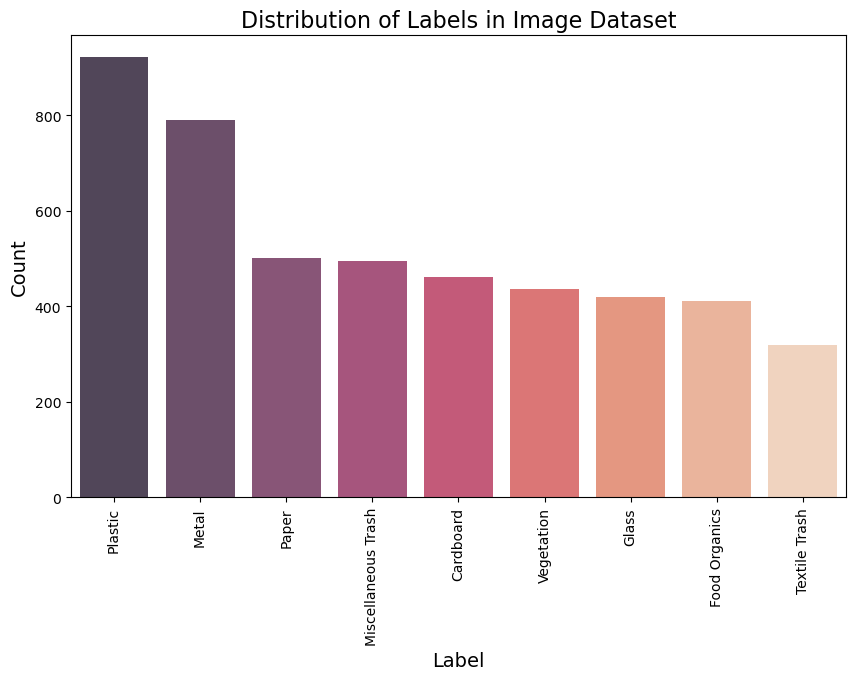

In [40]:
label_counts = image_df['Label'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.show()

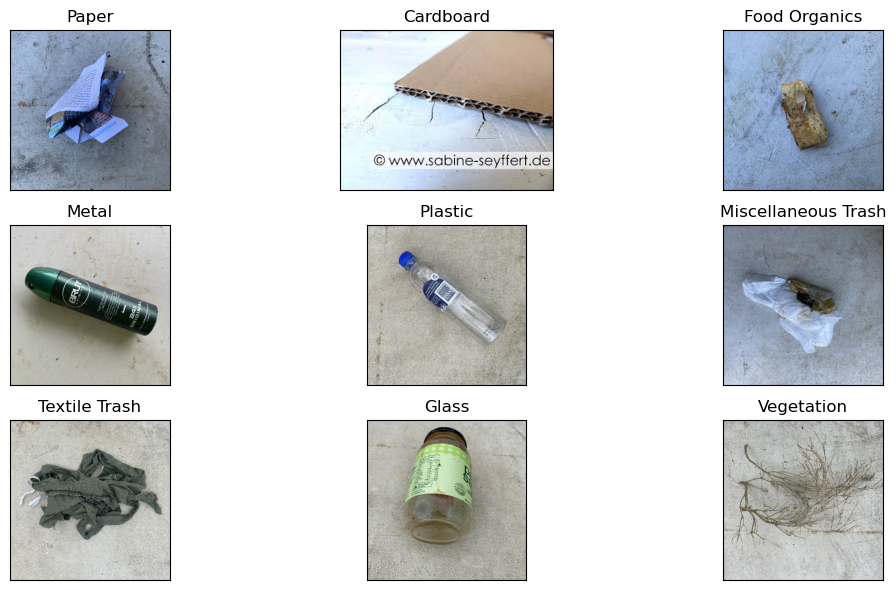

In [41]:
# Chọn ngẫu nhiên 9 loại rác thải khác nhau
unique_labels = image_df.Label.unique()  # Lấy danh sách các nhãn khác nhau
random_samples = [image_df[image_df.Label == label].sample(1) for label in np.random.choice(unique_labels, 9, replace=False)]
selected_images = pd.concat(random_samples)  # Gộp tất cả vào một DataFrame mới

# Hiển thị 9 hình ảnh với nhãn tương ứng
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []})

for ax, (_, row) in zip(axes.flat, selected_images.iterrows()):
    ax.imshow(plt.imread(row.Filepath))
    ax.set_title(row.Label)

plt.tight_layout()
plt.show()


In [42]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [43]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
train_generator = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input,
    validation_split=0.2
)

# Create the ImageDataGenerator for testing
test_generator = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input
)

In [44]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3041 validated image filenames belonging to 9 classes.
Found 760 validated image filenames belonging to 9 classes.
Found 951 validated image filenames belonging to 9 classes.


In [45]:
# xử lý ảnh trước khi đưa vào mạng neural networking
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),  
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),  
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1), # Tái chuẩn hóa giá trị pixel vào khoảng [0, 1].
])

In [47]:
# Khởi tạo mô hình MobileNetV3Large với trọng số đã huấn luyện trước
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


In [48]:
# Lưu lại mô hình tốt nhất
checkpoint_path = "Pest_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [49]:
# Dừng sớm nếu không cải thiện
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True)

In [50]:
# Đầu vào mô hình
inputs = pretrained_model.input
x = pretrained_model.output
x = Dense(256, activation='relu')(x)   # Học đặc trưng phức tạp hơn.
x = Dropout(0.2)(x)     # Dropout với tỷ lệ 20% để giảm overfitting.
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(9, activation='softmax')(x) # kích hoạt softmax cho bài toán phân loại đa lớp.

In [51]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.0001),    #  Cập nhật trọng số
    loss='categorical_crossentropy',     # Hàm mất mát dùng cho bài toán phân loại đa lớp 
    metrics=['accuracy']      # Theo dõi độ chính xác của mô hình trong quá trình huấn luyện
) 

In [52]:

log_dir = os.path.join("C:", "Data Analyts_2", "pest_classication_2")   

# Huấn luyện mô hình
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[  
        early_stopping,
        tf.keras.callbacks.TensorBoard(log_dir=log_dir),
        checkpoint_callback,
    ]
)

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 543ms/step - accuracy: 0.2805 - loss: 2.0171 - val_accuracy: 0.6342 - val_loss: 1.1885
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 549ms/step - accuracy: 0.6005 - loss: 1.1723 - val_accuracy: 0.7197 - val_loss: 0.8357
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 486ms/step - accuracy: 0.7189 - loss: 0.8599 - val_accuracy: 0.7526 - val_loss: 0.7076
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 472ms/step - accuracy: 0.7300 - loss: 0.7353 - val_accuracy: 0.7789 - val_loss: 0.6398
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 471ms/step - accuracy: 0.7968 - loss: 0.5850 - val_accuracy: 0.7908 - val_loss: 0.5941
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 468ms/step - accuracy: 0.8128 - loss: 0.5394 - val_accuracy: 0.7842 - val_loss: 0.5889
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 471ms/step - accuracy: 0.8494 - loss: 0.4670 - val_accuracy: 0.8053 - val_loss: 0.5430
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 485ms/step - accuracy: 0.8474 - loss: 0.4405 - 

In [53]:
results = model.evaluate(test_images, verbose=0)

print("Loss: {:.5f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

Loss: 0.39986
Accuracy: 85.28%


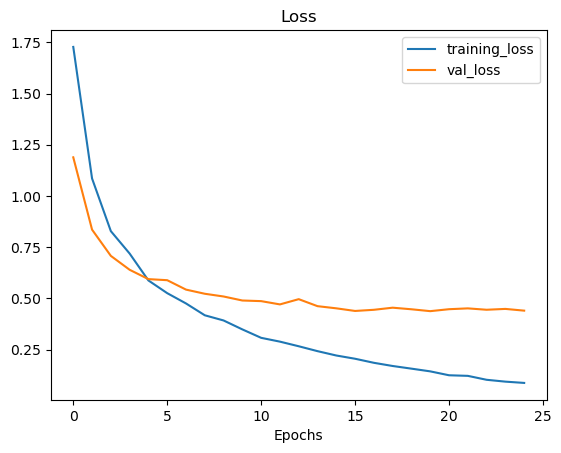

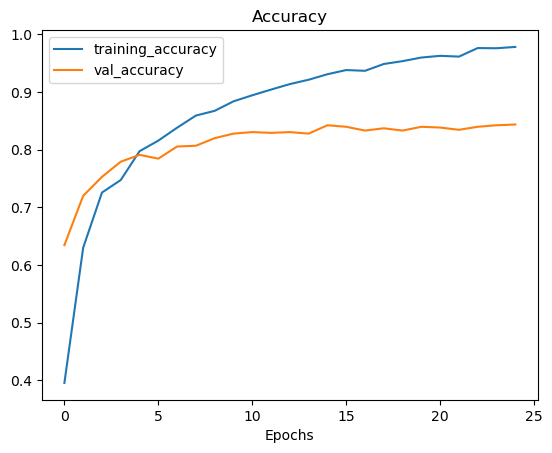

In [54]:
from helper_functions import plot_loss_curves
plot_loss_curves(history)

In [55]:
# Dự đoán xác suất thuộc các lớp cho từng ảnh
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 5 predictions: {pred[:5]}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step
The first 5 predictions: ['Plastic', 'Glass', 'Metal', 'Cardboard', 'Metal']


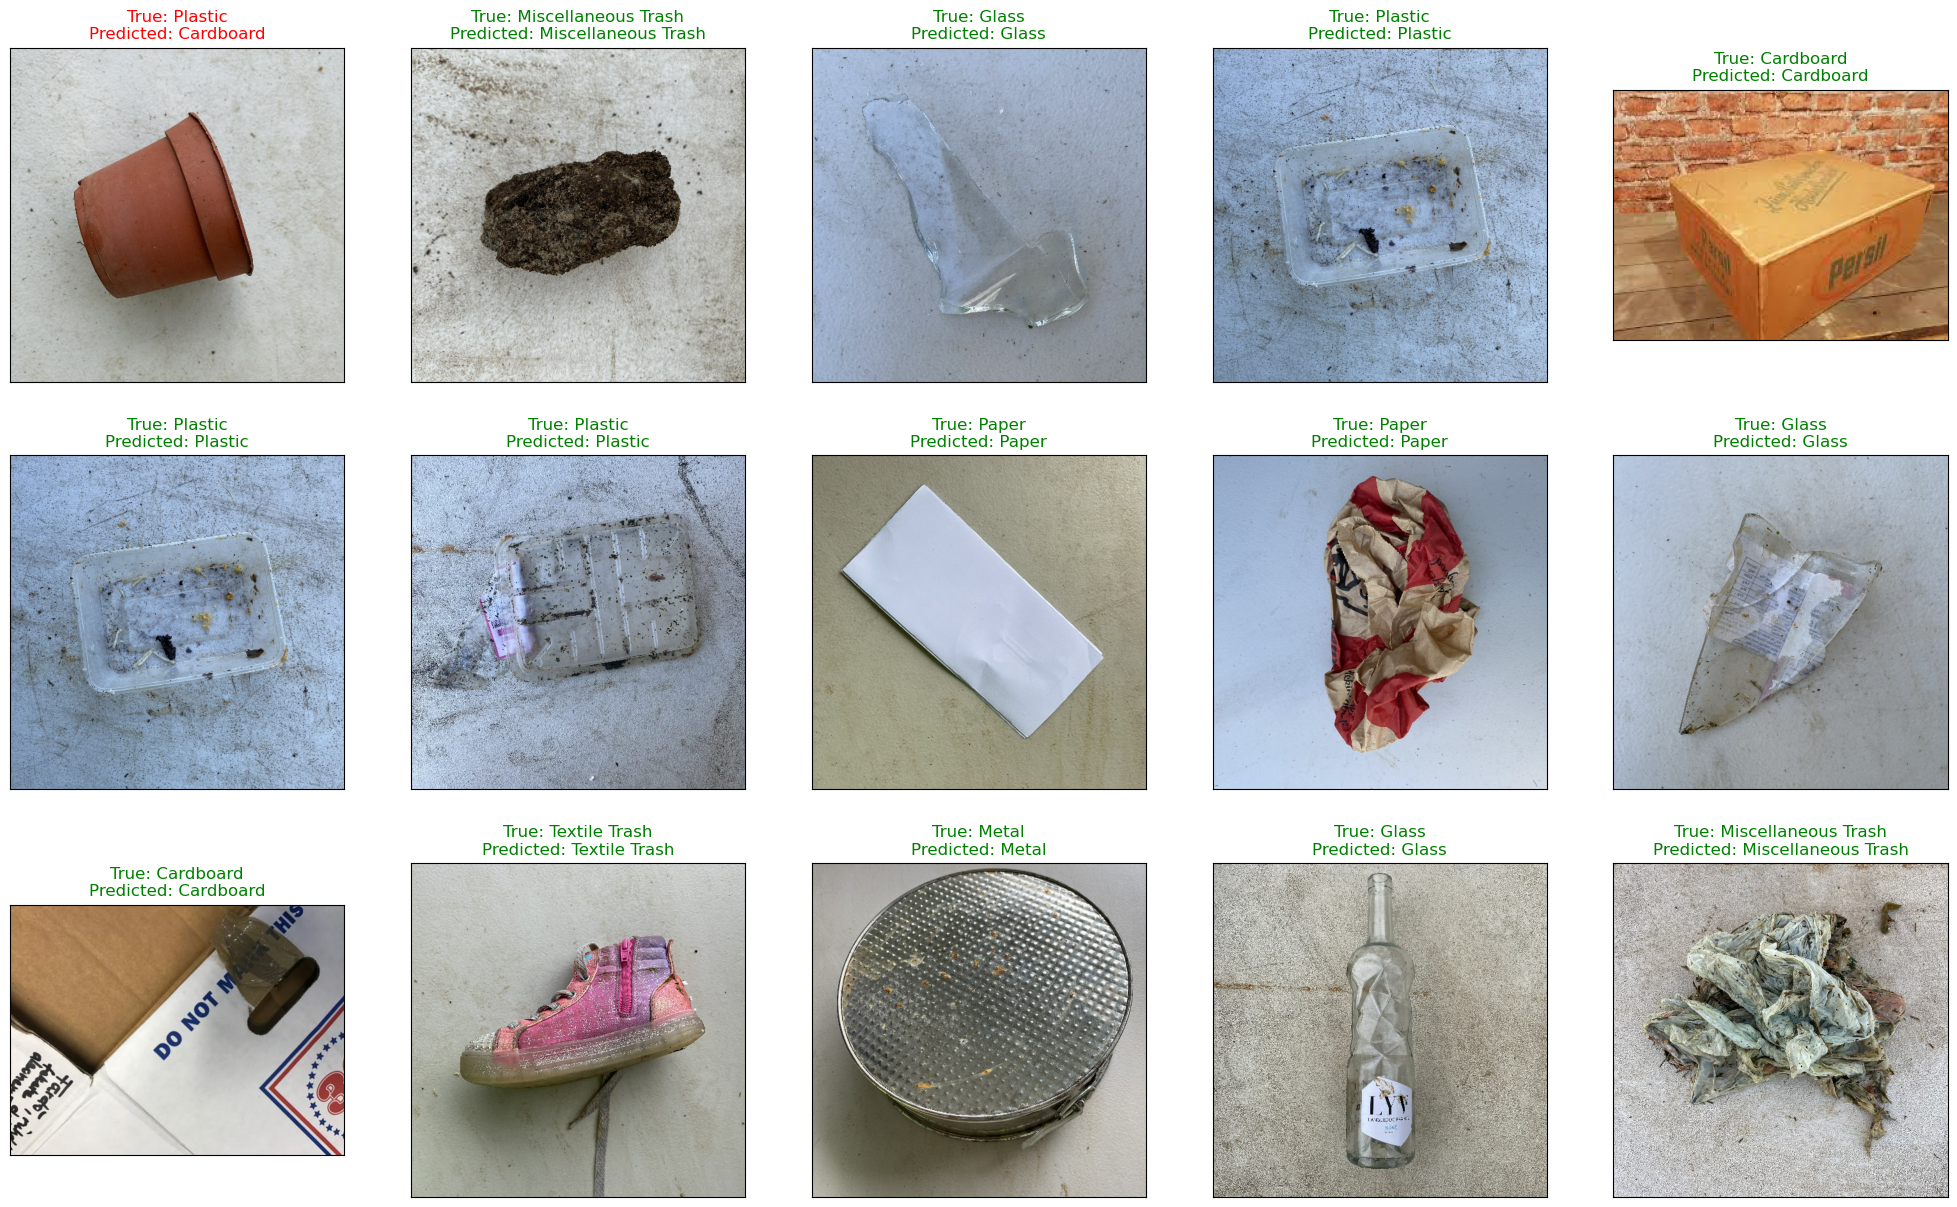

<Figure size 640x480 with 0 Axes>

In [63]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [57]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

          Cardboard       0.89      0.87      0.88        75
      Food Organics       0.84      0.89      0.87        85
              Glass       0.91      0.80      0.85        94
              Metal       0.84      0.86      0.85       162
Miscellaneous Trash       0.80      0.78      0.79        98
              Paper       0.89      0.90      0.89        98
            Plastic       0.82      0.85      0.84       188
      Textile Trash       0.84      0.84      0.84        68
         Vegetation       0.89      0.90      0.90        83

           accuracy                           0.85       951
          macro avg       0.86      0.85      0.86       951
       weighted avg       0.85      0.85      0.85       951



In [58]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Cardboard             0.890411  0.866667  0.878378   75.000000
Food Organics         0.844444  0.894118  0.868571   85.000000
Glass                 0.914634  0.797872  0.852273   94.000000
Metal                 0.842424  0.858025  0.850153  162.000000
Miscellaneous Trash   0.800000  0.775510  0.787565   98.000000
Paper                 0.888889  0.897959  0.893401   98.000000
Plastic               0.820513  0.851064  0.835509  188.000000
Textile Trash         0.838235  0.838235  0.838235   68.000000
Vegetation            0.892857  0.903614  0.898204   83.000000
accuracy              0.852787  0.852787  0.852787    0.852787
macro avg             0.859156  0.853674  0.855810  951.000000
weighted avg          0.853714  0.852787  0.852688  951.000000

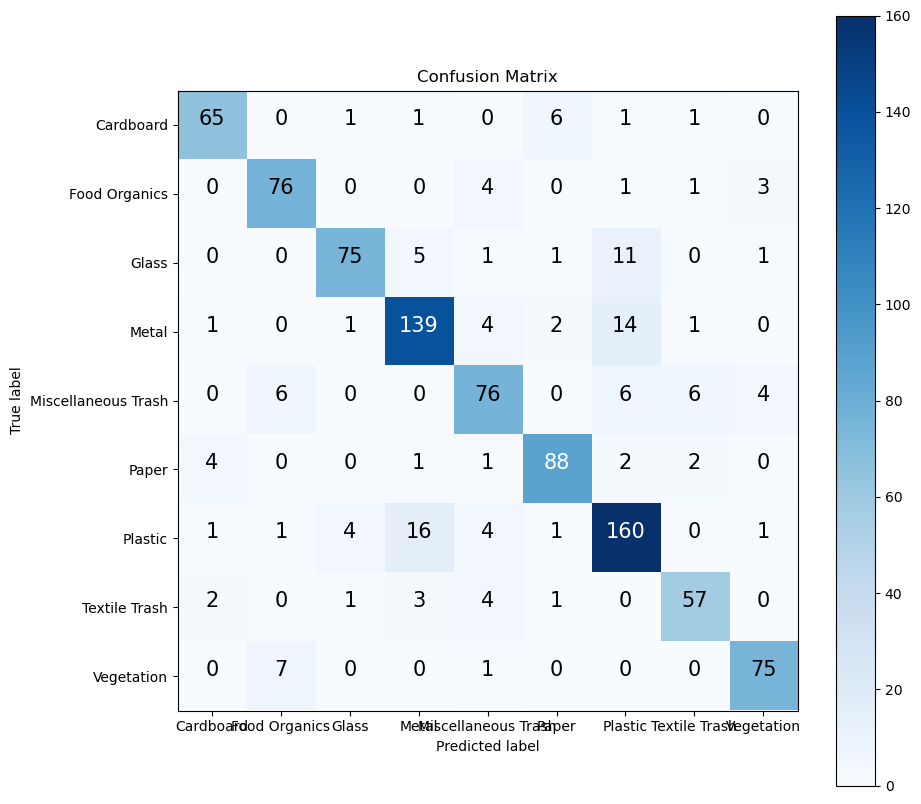

In [59]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_test, pred, list(labels.values()))


In [60]:
# import matplotlib.cm as cm

# # Grad-Cam Visualization
# def get_img_array(img_path, size):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
#     array = tf.keras.preprocessing.image.img_to_array(img)
#     # We add a dimension to transform our array into a "batch"
#     # of size "size"
#     array = np.expand_dims(array, axis=0)
#     return array

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # First, we create a model that maps the input image to the activations
#     # of the last conv layer as well as the output predictions
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]
#     # This is the gradient of the output neuron (top predicted or chosen)
#     # with regard to the output feature map of the last conv layer
#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     # This is a vector where each entry is the mean intensity of the gradient
#     # over a specific feature map channel
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the top predicted class
#     # then sum all the channels to obtain the heatmap class activation
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     # For visualization purpose, we will also normalize the heatmap between 0 & 1
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()
# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     # Load the original image
#     img = tf.keras.preprocessing.image.load_img(img_path)
#     img = tf.keras.preprocessing.image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
# #     display(Image(cam_path))
    
#     return cam_path
    

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# last_conv_layer_name = "expanded_conv_2_project"
# img_size = (224, 224)

# # Remove last layer's softmax
# model.layers[-1].activation = None

In [61]:
# # Display the part of the pictures used by the neural network to classify the pictures
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     img_path = test_df.Filepath.iloc[random_index[i]]
#     img_array = preprocess_input(get_img_array(img_path, size=img_size))
#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
#     cam_path = save_and_display_gradcam(img_path, heatmap)
#     ax.imshow(plt.imread(cam_path))
#     ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
# plt.tight_layout()
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


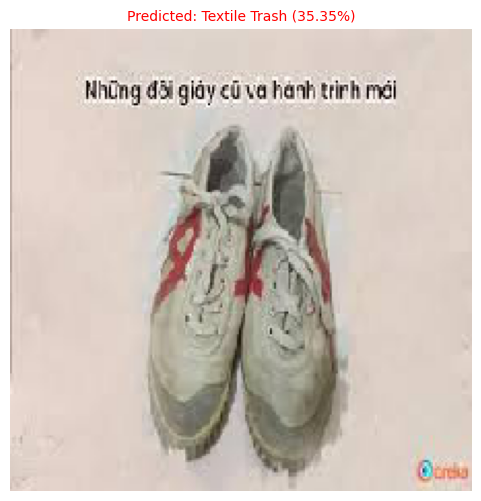

Predicted class: Textile Trash


In [79]:
# 🔹 Khởi tạo lại mô hình (phải giống lúc huấn luyện)
pretrained_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# 🔹 Nạp trọng số đã lưu
weights_path = r"C:\Users\admin\DAP\pest_classification_model_checkpoint.weights.h5"
model.load_weights(weights_path)

# 🔹 Danh sách nhãn lớp (phải giống thứ tự mô hình được huấn luyện)
class_labels = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", 
                "Paper", "Plastic", "Textile Trash", "Vegetation"]

def predict_and_show(model, image_path):
    """Hàm dự đoán và hiển thị ảnh với nhãn dự đoán"""

    # Tiền xử lý ảnh
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)  # Chuẩn hóa theo MobileNetV3
    

    # Dự đoán
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    
    predicted_class = class_labels[predicted_index]  # Lấy nhãn dự đoán
    confidence = predictions[0][predicted_index] * 100  # Lấy độ tin cậy

    # Hiển thị ảnh với kết quả dự đoán
    plt.figure(figsize=(6,6))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)", fontsize=10, color="red")
    plt.show()

    return predicted_class

# 🔹 Cập nhật đường dẫn đến ảnh cần kiểm tra
image_path = r"C:\Users\admin\DAP\Test\shoe.jpg"

# 🔹 Gọi hàm dự đoán
predicted_class = predict_and_show(model, image_path)
print("Predicted class:", predicted_class)
